In [1]:
#!pip install bambi git+https://github.com/yannmclatchie/kulprit.git

In [2]:
import pandas as pd
import numpy as np

import bambi as bmb
import kulprit as kpt

import arviz as az
import matplotlib.pyplot as plt

/Users/yannmclatchie/Desktop/kulprit/.venv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# define model data
data = data = bmb.load_data("my_data")

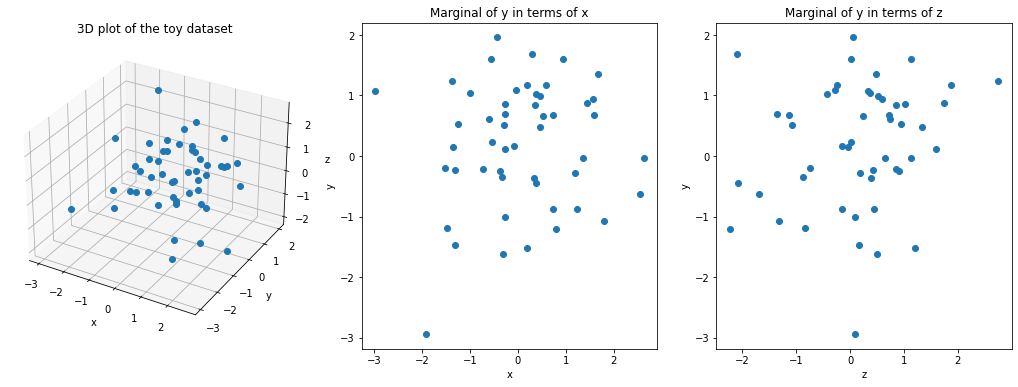

In [4]:
# plot the data
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(1, 3, 1, projection="3d")
ax.plot(data["x"], data["y"], data["z"], "o")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("3D plot of the toy dataset")

ax = fig.add_subplot(1, 3, 2)
ax.plot(data["x"], data["y"], "o")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Marginal of y in terms of x")

ax = fig.add_subplot(1, 3, 3)
ax.plot(data["z"], data["y"], "o")
ax.set_xlabel("z")
ax.set_ylabel("y")
ax.set_title("Marginal of y in terms of z")

plt.show()

In [5]:
# define and fit model with MCMC
model = bmb.Model("y ~ x + z", data, family="gaussian")
num_draws, num_chains = 2_000, 2
idata = model.fit(draws=num_draws, chains=num_chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_sigma, z, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 27 seconds.


In [6]:
# build reference model object
ref_model = kpt.ReferenceModel(model, idata)
# project the reference model to some parameter subset and plot posterior
sub_model = ref_model.project(terms=["x"])

/Users/yannmclatchie/Desktop/kulprit/src/kulprit/families/continuous.py:146: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  + 1 / self.data.structure.num_obs * (f - f_perp).T @ (f - f_perp)


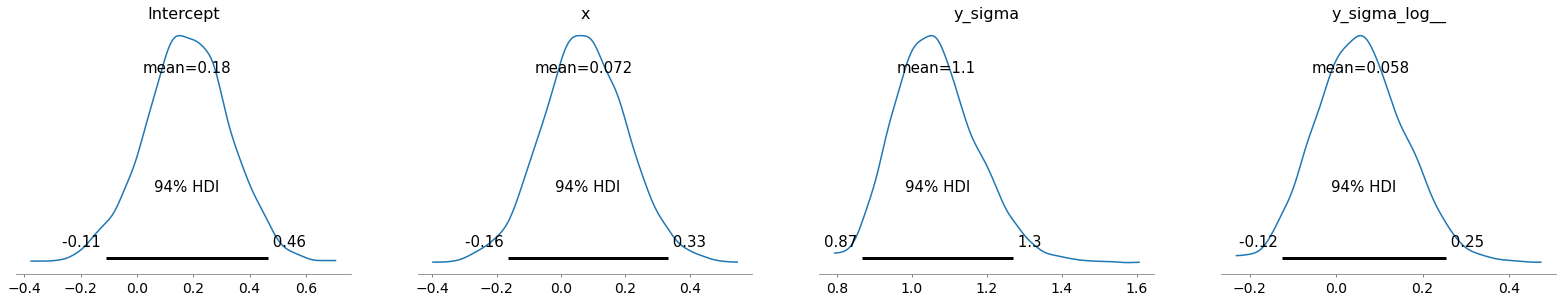

In [7]:
# visualise projected parameters
az.plot_posterior(sub_model.idata)
plt.show()

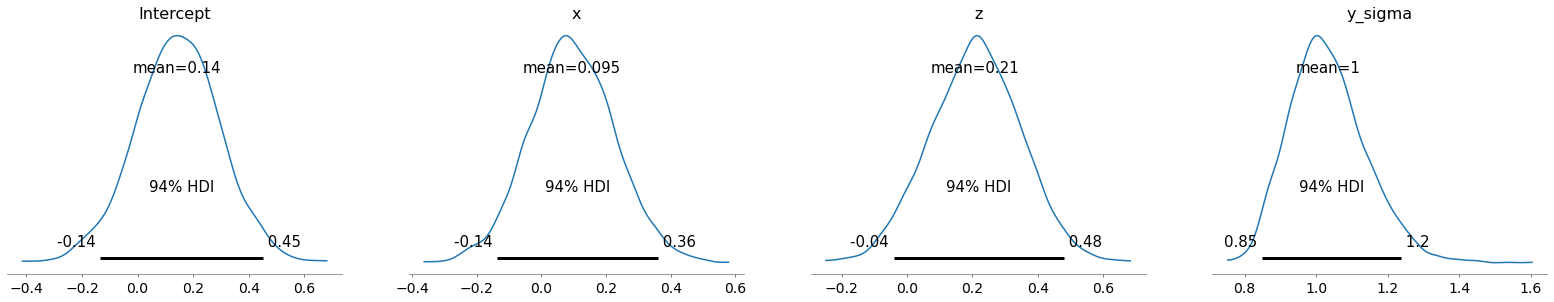

In [8]:
# compared to reference model
az.plot_posterior(idata, var_names=["Intercept", "x", "z", "y_sigma"])
plt.show()

In [9]:
# compare full and submodel predictive performance
az.compare(dict(full=idata, sub=sub_model.idata))

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
full,0,-74.613041,4.109642,0.000000,0.572226,5.659059,0.000000,False,log
sub,1,-74.681098,3.074141,0.068057,0.427774,5.188809,1.567038,False,log


In [10]:
# project with gradient descent and compare to analytic solution
analytic_sub_model = ref_model.project(terms=["x"], method="gradient")
az.compare(dict(analytic=sub_model.idata, gradient=analytic_sub_model.idata))

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
analytic,0,-74.681098,3.074141,0.000000,1.0,5.188809,0.000000,False,log
gradient,1,-76.456642,4.228287,1.775543,0.0,4.908991,0.339181,False,log
